# Table of Contents

1. [Load Libraries and Sagemaker](#Load-Libraries-&-Sagemaker-Session)
2. [Load Saved Files](#Load-saved-files)
3. [Download original files](#Download-original-files)
4. [EDA](#EDA)
    - [Data Cleaning and Preparation](#Data-cleaning-and-preparation)
    - [Drugs names](#Drug-names)
    - [Condition](#Condition)
    - [Sentiment](#Sentiment)
    - [Joint Probabilities and Mutual Information](#Joint-Probabilities-and-Mutual-Information)
5. [Bag of Words: Cvectorizer and TfIdfVectorizer](#Bag-of-Words:-CVectorizer-and-TfIdfVectorizer)
    - [Create Vocabulary](#Create-Vocabulary)
    - [Cvectorizers](#Cvectorizers)
    - [TfIdfVectorizers](#TfIdfVectorizer)
6. [LSTM model data preparation](#LSTM-model-data-preparation)
7. [Models Log File](#Models-Log-File)
8. [Condition=f(drug)](#Condition=f(drug))
    - [NB](#NB)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [Linear SVC](#Linear-SVC)
    - [Set Analysis](#Set-analysis)
9. [Condition=f(review)](#Condition=f(review))
    - [NB](#NB-model)
    - [Random Forest](#Random-Forest)
    - [XGboost](#XGboost)
    - [FeedFoward-NN Pytorch](#FeedFoward-NN-Pytorch)
10. [Sentiment=f(review)](#Sentiment=f(review))
    - [NB model](#Naive-Bayes)
    - [LSVC](#LSVC)
    - [Random Forest](#Random-Forest-Clf.)
    - [FeedFowardNN Pytorch](#FeedFowardNN-Pytorch)
    - [LSTM Pytorch](#LSTM-Pytorch)

# Load Libraries & Sagemaker Session

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re
from bs4 import BeautifulSoup
import pickle
import os
import itertools
from sys import getsizeof
from progressbar import progressbar
import numpy as np
import json 
from scipy import sparse

import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set()

Parallel processing

In [ ]:
import multiprocessing as mp

SKLearn libs + Counter + XGboost

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer

from collections import Counter

Pytorch libs

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

S3 and Sagemaker

In [4]:
import logging
import boto3
from botocore.exceptions import ClientError
import sagemaker

In [5]:
session = boto3.Session(profile_name='default')
sagemaker_session = sagemaker.Session(boto_session=session)

bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role(sagemaker_session=sagemaker_session)

# Load saved files

Since several files are created throughout the analysis, some of them using a lot of memory, I decided to save them and then load the file if needed. 

Load clean dataframe ('full_data.csv'). This is the result of cleaning original files and joining train and test data.

In [4]:
data=pd.read_csv('full_data.csv',index_col=0)

Load word-count object ('word_count.pkl'). Contains the full vocabulary and corresponding word (tokenized version) counts.

In [ ]:
word_count=pickle.load(open('word_count.pkl','rb'))

Load drug_per_condition object. It is a Pandas.Series object containing all the different conditions and corresponding drug names in a form of a list.

In [4]:
drug_per_condition=pickle.load(open('drug_per_condition.pkl','rb'))

Vocabulary size for each file. It retrieves the dimension of the vocabulary given the file name.

In [1]:
vocab_file={'reviews_cv5k.pkl':5000,
           'reviews_cv10k.pkl':10000,
           'reviews_cv20k.pkl':20000,
           'reviews_cv50k.pkl':48319,
           'reviews_tv5k.pkl':5000,
           'reviews_tv10k.pkl':10000,
           'reviews_tv20k.pkl':20000,
           'reviews_tv50k.pkl':48319,
           'reviews_seq_csr50k.pkl':48319,
           'reviews_seq_csr10k.pkl':10000}

**Load Reviews in csr_matrix format. Count-vectorizers**

In [4]:
#for a vocabulary with 5000 words
reviews_cv5k=pickle.load(open('reviews_cv5k.pkl','rb'))

In [ ]:
#for a vocabulary with 10000 words
reviews_cv10k=pickle.load(open('reviews_cv10k.pkl','rb'))

In [ ]:
#for a vocabulary with 20000
reviews_cv20k=pickle.load(open('reviews_cv20k.pkl','rb'))

In [22]:
#for the full vocabulary
reviews_cv50k=pickle.load(open('reviews_cv50k.pkl','rb'))

In [23]:
reviews_cv50k.shape[1]

48319

**TfIdf vectorizers**

In [ ]:
#for a vocabulary with 5000 words
reviews_tv5k=pickle.load(open('reviews_tv5k.pkl','rb'))

In [16]:
#for a vocabulary with 10000 words
reviews_tv10k=pickle.load(open('reviews_tv10k.pkl','rb'))

In [ ]:
#for a vocabulary with 20000
reviews_tv20k=pickle.load(open('reviews_tv20k.pkl','rb'))

In [5]:
#for the full vocabulary
reviews_tv50k=pickle.load(open('reviews_tv50k.pkl','rb'))

**Reviews to list**: it is a list of lists. Each entry contains the tokenized version of a review keeping the order of words. This is used to transform the review into a sequence of integers which we feed to the LSTM. Since we are testing multiple vocabularies this data is very useful.

In [ ]:
review_to_list=pickle.load(open('review_to_list.pkl','rb'))

**LSTM files**: this is the transformed version of the reviews into arrays of integers using the full vocabulary ("reviews_seq_csr50k") and a shorter version of the vocabulary ("reviews_seq_csr10k"). We use csr_matrix format for better use of space and memory. When we send to training in the remote instance the sparse matrices are transformed into dense format. If loaded into your computer be aware that a large protion of memory will be used.

In [6]:
#for the full vocabulary
reviews_seq_csr50k=pickle.load(open('reviews_seq_csr50k.pkl','rb'))

In [ ]:
#for a vocabulary with 10000 words
reviews_seq_csr10=pickle.load(open('reviews_seq_csr10k.pkl','rb'))

# Download original files

Download from UCI repo

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip

In [ ]:
!unzip drugsCom_raw.zip

Load original files as a train and test dataframes

In [ ]:
"""
reads the original tsv files
"""
def read_data():
    data_train = pd.read_csv('drugsComTrain_raw.tsv', sep='\t',index_col=0)
    data_test = pd.read_csv('drugsComTest_raw.tsv', sep='\t',index_col=0)

    return data_train, data_test

data_train,data_test=read_data()

In [ ]:
data_train.info()

In [ ]:
data_test.info()

# EDA

## Data cleaning and preparation

Clean data, remove rows with Nan values and rows with wrongly assigned conditions. Some patient conditions were not correctly assigned. They have html tags, so I use this to remove them from the dataset. 

In [ ]:
"""
removes rows with Nan values, cleans the reviews from html tags and deletes wrongly assigned conditions.
Some conditions have names that do not correspond to real patient conditions.
"""
def clean_train_test():
    
    train_df= data_train.dropna()
    test_df = data_test.dropna()

    def resub(review):
        review = BeautifulSoup(review,'lxml').text #remove html tags including the "&#039"
        return review

    train_df.review = train_df.review.apply(resub)
    test_df.review = test_df.review.apply(resub)

    train_df = train_df[~train_df.condition.str.contains('</span>')]
    test_df = test_df[~test_df.condition.str.contains('</span>')]

    return train_df, test_df

In [ ]:
train_df,test_df=clean_train_test()

In [ ]:
train_df.head()

Join Train and Test dataframes

In [ ]:
data=pd.concat([train_df,test_df])

In [ ]:
data.info()

In [ ]:
#save data
data.to_csv('full_data.csv')

## Drug names

In [5]:
drug_names=data.drugName.value_counts()

In [6]:
drug_names

Levonorgestrel                         4896
Etonogestrel                           4402
Ethinyl estradiol / norethindrone      3619
Nexplanon                              2883
Ethinyl estradiol / norgestimate       2682
                                       ... 
Topical Anesthetic Dental Gel             1
Zetran                                    1
Motrin Infant Drops                       1
Ibudone                                   1
Gramicidin / neomycin / polymyxin b       1
Name: drugName, Length: 3654, dtype: int64

Drugs per condition

In [7]:
drug_per_condition=data.groupby(['condition'])['drugName'].apply(lambda x: [el for el in x])

In [8]:
drug_per_condition

condition
ADHD                           [Guanfacine, Daytrana, Intuniv, Focalin, Vyvan...
AIDS Related Wasting           [Somatropin, Dronabinol, Marinol, Dronabinol, ...
AV Heart Block                                                     [Epinephrine]
Abdominal Distension                                   [Urecholine, Bethanechol]
Abnormal Uterine Bleeding      [Provera, Medroxyprogesterone, Medroxyprogeste...
                                                     ...                        
unctional Gastric Disorde                                          [Simethicone]
ungal Infection Prophylaxis                                       [Itraconazole]
ungal Pneumonia                                                    [Fluconazole]
von Willebrand's Disease       [Stimate, Stimate, Antihemophilic factor / von...
zen Shoulde                    [Diclofenac, Indocin, Naproxen, Naproxen, Dicl...
Name: drugName, Length: 836, dtype: object

Save with Pickle

In [ ]:
pickle.dump(drug_per_condition,open('drug_per_condition.pkl','wb'))

## Condition

In [5]:
num_classes=len(set(data.condition))
print(num_classes)

836


In [6]:
condition_dstrb=data.condition.value_counts()/data.shape[0]*100
condition_dstrb

Birth Control                         18.070692
Depression                             5.718907
Pain                                   3.876388
Anxiety                                3.672813
Acne                                   3.495566
                                        ...    
Short Stature                          0.000470
Paragonimus westermani, Lung Fluke     0.000470
Rat-bite Feve                          0.000470
Thyroid Suppression Test               0.000470
Neoplastic Diseases                    0.000470
Name: condition, Length: 836, dtype: float64

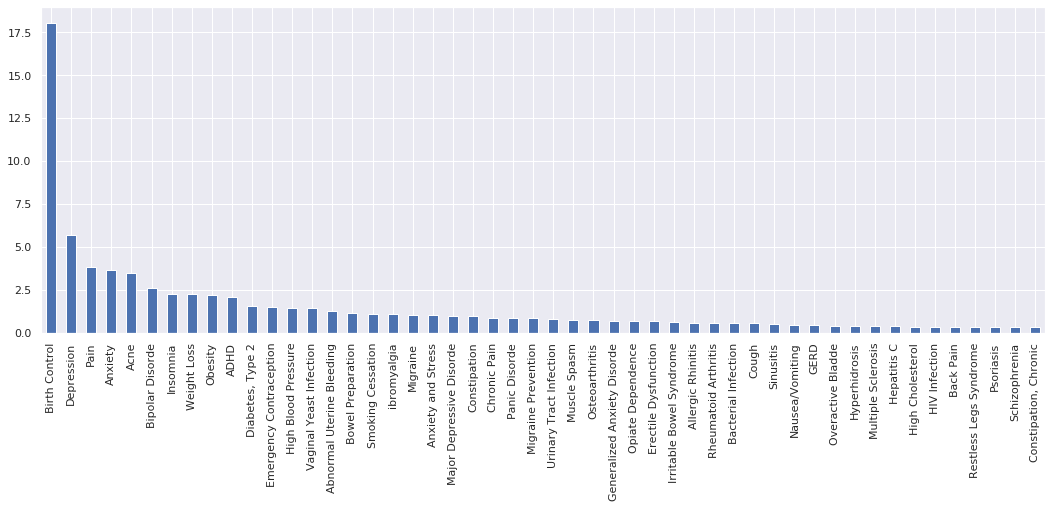

In [27]:
plt.figure(figsize=(18,6))
condition_dstrb[:50].plot(kind='bar')
plt.savefig('condition_plot.jpg')
plt.show()

The dataset is very unbalanced. One can see that there are several conditions that appear very sporadically. 

In [28]:
"""
Creates table with cumulative frequency for conditions appearing within the intervals shown below.
"""
intervals=[(0,2.5),(2.5,5),(5,10),(10,50),(50,100)]

values=[]
cnts=[]
for interval in intervals:
    value=condition_dstrb[(condition_dstrb>interval[0]) & (condition_dstrb<=interval[1]) ].sum()
    cnt=condition_dstrb[(condition_dstrb>interval[0]) & (condition_dstrb<=interval[1]) ].count()
    values.append(round(value,1))
    cnts.append(cnt)

In [29]:
intvals=["<=2.5%","[2.5%,5%]","[5%,10%]","[10%,50%]",">50%"]
pd.Series(values,index=intvals)

<=2.5%       62.5
[2.5%,5%]    13.7
[5%,10%]      5.7
[10%,50%]    18.1
>50%          0.0
dtype: float64

Aggregate conditions that appear less than a certain threshold: 0.1%, 0.05% and 0.01%, into a bigger class named "other".

In [ ]:
cond_aux=pd.DataFrame.from_dict({"condition":condition_dstrb.index,"percentage":condition_dstrb.values})

In [ ]:
threshold=0.1
def change(row):
    if row[1]<=threshold:
        row[0]='other'
        return row
    else:
        return row

In [ ]:
cond_01=cond_aux.apply(change,axis=1)
threshold=0.05
cond_005=cond_aux.apply(change,axis=1)
threshold=0.01
cond_001=cond_aux.apply(change,axis=1)

In [ ]:
cond_01=cond_01.groupby('condition')['percentage'].sum().sort_values(ascending=False)

In [ ]:
cond005=cond_005.groupby('condition')['percentage'].sum().sort_values(ascending=False)

In [ ]:
cond001=cond_001.groupby('condition')['percentage'].sum().sort_values(ascending=False)

Create new columns for the different aggregations. Join conditions with frequency less than 0.1%, 0.05% and 0.01% into a new category called "other".

In [ ]:
"""
reduce number of conditions using pvalue threshold
"""
def reduce_conditions(pvalue):
    cond = condition_dstrb > pvalue

    def g(condition):
        if cond[condition]:
            return condition
        else:
            return 'other'

    data['condition-'+str(pvalue)] = data['condition'].apply(g)

In [ ]:
pvalues=[0.1,0.05,0.01]
for pvalue in pvalues:
    reduce_conditions(pvalue)

## Sentiment

In [30]:
ratings=set(data.rating)

In [31]:
min(ratings), max(ratings)

(1.0, 10.0)

In [32]:
#check that ratings are integers
(data.rating.values-data.rating.values.astype(int)).sum()

0.0

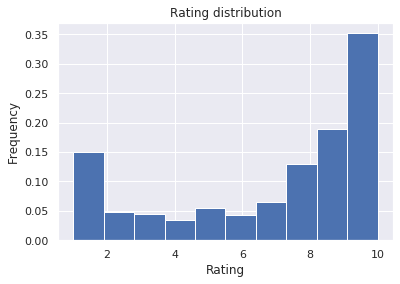

In [33]:
plt.hist(data.rating,bins=10,density=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating distribution')
plt.show()

In [34]:
rating_distrib=data.rating.value_counts()/data.shape[0]*100

Create sentiment: negative <5.0, neutral==5.0, positive >5.0

In [ ]:
"""
Create positive, neutral and negative sentiments
"""
data['sentiment']=data.rating

def sentiment(rating):
    if rating>5.0:
        return 'positive'
    if rating==5.0:
        return 'neutral'
    if rating<5.0:
        return 'negative'
    
data['sentiment']=data['sentiment'].apply(sentiment)

In [ ]:
data.head()

In [36]:
sentiment_dstrb=data.sentiment.value_counts()/data.shape[0]*100
sentiment_dstrb

positive    70.135121
negative    24.891160
neutral      4.973719
Name: sentiment, dtype: float64

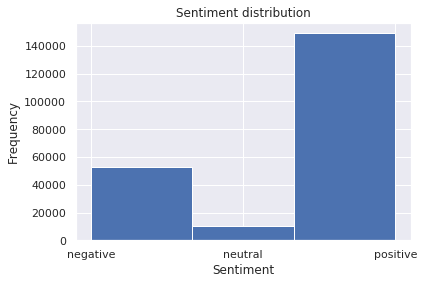

In [37]:
plt.hist(data.sentiment.sort_values(),bins=3)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment distribution')
plt.show()

## Joint Probabilities and Mutual Information

The mutual information gives us an average value of $\ln\left(\frac{P(x,y)}{P(x)P(y)}\right)$. So if we exponentiate this we have an estimate for the ratio $\frac{P(x,y)}{P(x)P(y)}$. Closer this value is to 1, less is the correlation.

In [ ]:
# Number of words in each review 
reviews_lens=[len(review) for review in review_to_list]

In [ ]:
"""
create list by keeping the most commond word of each review
"""
most_common_word=[]
for row in reviews_seq_csr:
    try:
        word=Counter(row.data[1:]).most_common(1)[0][0]
        most_common_word.append(word)
    except:
        most_common_word.append(0)
most_common_word=np.array(most_common_word)

Calculate mutual information between the different variables

In [ ]:
"""
Calculate matrix of mutual information scores (normalized)
"""

cols=['drugName','condition','review_len','mstcmn_word','usefulCount','sentiment','rating']
items=['data.drugName','data.condition','reviews_lens','most_common_word','data.usefulCount','data.sentiment','data.rating']

mut_info={}
for name,item1 in zip(cols,items):
    mut_info[name]=[]
    for item2 in items:
        mut_info[name].append(normalized_mutual_info_score(eval(item1),eval(item2)))

In [ ]:
mutual_info_df=pd.DataFrame.from_dict(mut_info)
mutual_info_df.index=cols

In [ ]:
mutual_info_df

# Bag of Words: CVectorizer and TfIdfVectorizer

## Create Vocabulary 

In [ ]:
#Tokenizer function. Remove stop-words, and use Porter Stemmer algorithm
porter_stemmer = PorterStemmer()
nltk.download('stopwords')
def tknizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words if word not in stopwords.words('english')]
    return words

**Use multiprocessing** to tokenize reviews and create dictionary. This speeds-up considerably the calculation and allows to build very large dictionaries.

In [ ]:
mp.cpu_count()

In [ ]:
#this function is used to feed the multprocessing.map() function
def revs_to_list(review):
    rev_tknized=tknizer(review)
    return rev_tknized

Create list of tokenized reviews

In [ ]:
reviews=data.review.values

In [ ]:
#parallelizes tokenization of the reviews
with mp.Pool(mp.cpu_count()) as pool:
    review_to_list=pool.map(revs_to_list,reviews)

In [ ]:
pickle.dump(review_to_list,open('review_to_list.pkl','wb'))

Create dictionary. In order to use multiprocessing, we create a function that returns a Counter() for each review_list.

In [ ]:
def cnt_words(lst):
    m=Counter(lst)
    return m

In [ ]:
#apply the Counter in parallel to each review
with mp.Pool(mp.cpu_count()) as pool:
    word_cnts=pool.map(cnt_words,result)

We create batches that we feed to the various cpus. At end we only need to run a simple loop to finalize. All process takes less than a minute to finalize (compare to around 1 hour using just a for loop).

In [ ]:
def batch_update(batch):
    a=batch[0]
    for b in batch[1:]:
        a.update(b)
    return a

In [ ]:
batch_size=10000 #choose batch size
L=len(word_cnts)
batches=[word_cnts[i:i+batch_size] for i in range(0,L,batch_size)]

In [ ]:
#feed batches to multiprocessing
with mp.Pool(mp.cpu_count()) as pool:
    word_batches=pool.map(batch_update,batches)

In [ ]:
word_count=word_batches[0]
for a in word_batches[1:]:
    word_count.update(a)

In [ ]:
pickle.dump(word_count,open('word_count.pkl','wb'))

## Cvectorizers

Now that we have the full vocabulary and word counts, we consider vocabularies of dimension 5000,10000 and 20000. I create a function to vectorize arrays of words into sparse matrices. I use multiprocessing to parallelize the process.

### D=5k

In [ ]:
d=5000

In [ ]:
#create vocabulary
vocab5k=word_count.most_common(5000)
vocab5k={word[0]:i for i,word in enumerate(vocab5k)}

In [ ]:
VOCAB=vocab5k

In [ ]:
"""
transforms list of words to sparse matrix of word counts
"""
def to_csr(review_list):
    m=Counter(review_list)
    indices=[]
    values=[]
    for word,cnt in m.items():
        try:
            indices.append(VOCAB[word])
            values.append(cnt)
        except:
            continue
    A=csr_matrix((values,([0]*len(indices),indices)),shape=(1,len(VOCAB)),dtype=int)
   
    return A

In [ ]:
with mp.Pool(mp.cpu_count()) as pool:
    reviews_csr_row=pool.map(to_csr,review_to_list)

In [ ]:
reviews_cv5k=vstack(reviews_csr_row)

In [ ]:
reviews_cv5k

In [ ]:
pickle.dump(reviews_cv5k,open('reviews_cv5k.pkl','wb'))

**Check how many reviews are mapped to zero vectors**

In [ ]:
nnz_elems_5k=[row.getnnz() for row in reviews_cv5k]

In [ ]:
max(nnz_elems_5k)

In [ ]:
min(nnz_elems_5k)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(nnz_elems_5k,bins=100,density=True)
plt.show()

In [ ]:
nnz=Counter(nnz_elems_5k)

In [ ]:
#number of rows with zero elements
nnz[0]

### D=10k

In [ ]:
d=10000

In [ ]:
vocab10k=word_count.most_common(d)
vocab10k={word[0]:i for i,word in enumerate(vocab10k)}

In [ ]:
# need to assign this variable so the function to_csr() works correctly 
VOCAB=vocab10k

In [ ]:
with mp.Pool(mp.cpu_count()) as pool:
    reviews_csr_row=pool.map(to_csr,review_to_list)

In [ ]:
reviews_cv10k=vstack(reviews_csr_row)

In [ ]:
pickle.dump(reviews_cv10k,open('reviews_cv10k.pkl','wb'))

In [ ]:
nnz_elems_10k=[row.getnnz() for row in reviews_cv10k]

In [ ]:
nnz_10k=Counter(nnz_elems_10k)

In [ ]:
#number of rows with zero elements
nnz_10k[0]

### D=20k

In [ ]:
d=20000

In [ ]:
vocab20k=word_count.most_common(d)
vocab20k={word[0]:i for i,word in enumerate(vocab20k)}

In [ ]:
# need to assign this variable so the function to_csr() works correctly
VOCAB=vocab20k

In [ ]:
with mp.Pool(mp.cpu_count()) as pool:
    reviews_csr_row=pool.map(to_csr,review_to_list)

In [ ]:
reviews_cv20k=vstack(reviews_csr_row)

In [ ]:
pickle.dump(reviews_cv20k,open('reviews_cv20k.pkl','wb'))

In [ ]:
nnz_elems_20k=[row.getnnz() for row in reviews_cv20k]

In [ ]:
nnz_20k=Counter(nnz_elems_20k)

In [ ]:
nnz_20k[0]

### D=full (~50k)

In [ ]:
#vocabulary length
d=len(word_count)
print(d)

In [ ]:
vocab50k=word_count.most_common() #all vocabulary
vocab50k={word[0]:i for i,word in enumerate(vocab50k)}

In [ ]:
# need to assign this variable so the function to_csr() works correctly
VOCAB=vocab50k

In [ ]:
with mp.Pool(mp.cpu_count()) as pool:
    reviews_csr_row=pool.map(to_csr,review_to_list)

In [ ]:
reviews_cv50k=vstack(reviews_csr_row)

In [ ]:
pickle.dump(reviews_cv50k,open('reviews_cv50k.pkl','wb'))

In [ ]:
nnz_elems_50k=[row.getnnz() for row in reviews_cv50k]

In [ ]:
nnz_50k=Counter(nnz_elems_50k)

In [ ]:
nnz_50k[0]

## TfIdfVectorizers

We can use the Tfidf-Transformer to transform the sparse counting matrix to a Tfidf-sparse matrix.

In [ ]:
tfidf_transf=TfidfTransformer()

In [ ]:
reviews_tv5k=tfidf_transf.fit_transform(reviews_cv5k)

In [ ]:
reviews_tv10k=tfidf_transf.fit_transform(reviews_cv10k)

In [ ]:
reviews_tv20k=tfidf_transf.fit_transform(reviews_cv20k)

In [ ]:
reviews_tv50k=tfidf_transf.fit_transform(reviews_cv50k)

In [ ]:
files=['reviews_tv5k','reviews_tv10k','reviews_tv20k','reviews_tv50k']
for file in files:
    pickle.dump(eval(file),open(file+'.pkl','wb'))

# LSTM model data preparation

In this section I prepare the data for the LSTM pytorch model. I use already prepared file "review_to_list", which contains the tokenized version of the reviews in a list of lists. I have only considered vocabularies of sizes 10k and the full vocabulary. The training of the LSTM is more expensive so I decided to simplify the analysis.

In [ ]:
#load list of tokenized reviews
review_to_list=pickle.load(open('review_to_list.pkl','rb'))

In [ ]:
review_to_list[0]

Load full vocabulary

In [ ]:
word_count=pickle.load(open('word_count.pkl','rb'))
print(dict_len=len(word_count))

## D=10k

Use the 10000 most common words.

In [ ]:
#size of dictionary
vocab_size=10000
word_dic={word[0]:i+1 for i,word in enumerate(word_count.most_common(vocab_size))}
print(len(word_dic))

Convert sequence of words into sequence of integers using word_dic mapping

In [ ]:
lens=[len(lst) for lst in review_to_list]
pad=max(lens)# create pad
print(pad)
print(min(lens))
print(len(lens))

In [ ]:
# create function to feed to multiprocessing. Returns csr_matrix format for each review
def seq_to_seq(sequence):
    seq=np.zeros(pad+1,int)
    seq[0]=min(len(sequence),pad)
    
    for i,word in enumerate(sequence[:pad]):
        try:
            seq[i+1]=word_dic[word]
        except:
            #thats because word is not in dic
            continue
    
    return sparse.csr_matrix(seq)

In [ ]:
with mp.Pool(mp.cpu_count()) as pool:
    reviews_seq=pool.map(seq_to_seq,[seq for seq in review_to_list])

In [ ]:
#stack all the sparse rows into a larger sparse matrix
reviews_seq10k=sparse.vstack(reviews_seq)

In [ ]:
pickle.dump(reviews_seq10k,open('reviews_seq_csr10k.pkl','wb'))

## D~50k

**Use full vocabulary. Carefull with amount of memory used!**

In [ ]:
#size of dictionary
word_dic={word[0]:i+1 for i,word in enumerate(word_count.most_common())}
print(len(word_dic))

Convert sequence of words into sequence of integers using word_dic mapping

In [ ]:
lens=[len(lst) for lst in review_to_list]
pad=max(lens)# create pad
print(pad)
print(min(lens))
print(len(lens))

In [ ]:
# create function to feed to multiprocessing. Returns csr_matrix format for each review
def seq_to_seq(sequence):
    seq=np.zeros(pad+1,int)
    seq[0]=min(len(sequence),pad)
    
    for i,word in enumerate(sequence[:pad]):
        try:
            seq[i+1]=word_dic[word]
        except:
            #thats because word is not in dic
            continue
    
    return sparse.csr_matrix(seq)

In [ ]:
with mp.Pool(mp.cpu_count()) as pool:
    reviews_seq=pool.map(seq_to_seq,[seq for seq in review_to_list])

In [ ]:
#stack all the sparse rows into a larger sparse matrix
reviews_seq50k=sparse.vstack(reviews_seq)

In [ ]:
pickle.dump(reviews_seq50k,open('reviews_seq_csr50k.pkl','wb'))

# Models Log File

We study several functions:
* **condition=f(drug)**: condition as a function of drug name;
* **condition=f(review)**: condition as a function of the review;
* **sentiment=f(review)**: sentiment as a function of the review;

To keep track of model accuracies and parameters, I have created the following class which creates logs for the machine learning models. That is, it keeps track of the model name, input and target data, as well as hyperparameters, train and test accuracy. The data is stored in a csv file "model_logs.csv". When the objst is intialized it loads automatically the model_logs.csv, if it exists one.

In [6]:
class model_logs():
    """
    __init__(): either loads a saved log file or creates an empty one
    add_SKLmodel(): add train and test data for a SKlearn model. It calculates train and test accuracy and adds it to the log dataframe
    add_row(): add information in the form of a string: "model_name/data_X,/data_y/params dictionary/train accuracy/test accuracy"
    delete(): deletes all the stored data and creates an empty dataframe
    remove_row(): removes row given index of the dataframe
    save_data(): saves the dataframe to a csv file
    """
    
    def __init__(self,model_name=None,data_X=None,data_y=None):
        
        self.model_name=model_name
        self.data_X_name=data_X
        self.data_y_name=data_y
        
        print("X data: ", self.data_X_name)
        print("Y data: ",self.data_y_name)
        print("model name: ",self.model_name)
        
        try:
            self.log_data=pd.read_csv('model_logs.csv',index_col=0)
            self.log_data.reset_index(drop=True,inplace=True)
        except:
            #create empty dataframe
            print("No saved data available. Created empty log-data.")
            self.log_data=pd.DataFrame.from_dict({'name':[],'data_X':[],'data_y':[],'params':[],'train acc':[],'test acc':''})
            
    def add_SKLmodel(self,model,*args):
        if self.model_name==None or self.data_X_name==None or self.data_y_name==None:
            print("Some data is empty.")
            print("Model name: ",self.model_name)
            print("Data X: ",self.data_X_name)
            print("Data y: ",self.data_y_name)
        else:
            x_train,x_test,y_train,y_test=args
            preds_train = model.predict(x_train)
            acc_train = accuracy_score(preds_train, y_train)
            preds_test = model.predict(x_test)
            acc_test = accuracy_score(preds_test, y_test)

            dic=[self.model_name,self.data_X_name,self.data_y_name,json.dumps(model.get_params()),acc_train,acc_test]
            l=len(self.log_data)
            self.log_data.loc[l]=dic

            print('Train error: ', acc_train, '\nTest error: ', acc_test)
    
    def add_row(self,string):
        """ string: 'model_name/ data_X/ data_y/params/ train_acc/ test_acc' """
        description=string.split('/')
        self.model_name=description[0]
        self.data_X_name=description[1]
        self.data_y_name=description[2]
        params=description[3]
        train_acc=description[4]
        test_acc=description[5]
        
        dic=[self.model_name,self.data_X_name,self.data_y_name,params,train_acc,test_acc]
        l=len(self.log_data)
        self.log_data.loc[l]=dic
        
    def delete(self):
        self.log_data=pd.DataFrame.from_dict({'name':[],'data_X':[],'data_y':[],'params':[],'train acc':[],'test acc':''})
        
    def remove_row(self,row):
        self.log_data=self.log_data.drop([row])
        
    def save_data(self):
        self.log_data.to_csv('model_logs.csv')

In [7]:
logs=model_logs()

X data:  None
Y data:  None
model name:  None


In [8]:
logs.log_data

,name,data_X,data_y,params,train acc,test acc
0,random forest,reviews_cv5k,condition-0.05,"{""n_estimators"": 20, ""max_depth"": 500, ""max_fe...",0.992542,0.811025
1,random forest,reviews_cv5k,condition-0.05,"{""n_estimators"": 20, ""max_depth"": 700, ""max_fe...",0.993212,0.809121
2,random forest,reviews_cv5k,condition-0.05,"{""n_estimators"": 20, ""max_depth"": 300, ""max_fe...",0.978444,0.800259
3,random forest,reviews_cv5k,condition-0.05,"{""n_estimators"": 30, ""max_depth"": 300, ""max_fe...",0.981065,0.807029
4,NB,drugnames,condition-0.01,"{""alpha"": 1.0}",0.679175,0.674330
5,NB,drugnames,condition-0.01,"{""alpha"": 0.5}",0.697117,0.691114
6,NB,drugnames,condition-0.01,"{""alpha"": 0.01}",0.723874,0.713235
7,NB,drugnames,condition-0.01,"{""alpha"": 0.001}",0.724339,0.713893
8,Decision tree,drugnames,condition-0.01,"{""criterion"": ""gini"", ""max_depth"": 6000, ""max_...",0.724344,0.714504
9,random forest,drugnames,condition-0.01,"{""n_estimators"": 50, ""criterion"": ""entropy"", ""...",0.724297,0.714386


# Condition=f(drug)

In [ ]:
drug_per_condition

One-hot encode features (drug names)

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
X=data['drugName'].values
X=enc.fit_transform(X.reshape(-1,1))

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,data['condition-0.01'].values,test_size=0.2,random_state=42)

## NB

Multinomial Naive-Bayes

In [ ]:
params={'alpha':0.001}
NB=MultinomialNB(**params)

In [ ]:
NB.fit(x_train,y_train)

In [ ]:
logs.model_name='NB'
logs.data_X_name='drugnames'
logs.data_y_name='condition-0.01'
logs.add_SKLmodel(NB,x_train,x_test,y_train,y_test)

## Decision Tree

In [ ]:
params={'criterion':'gini', 'max_depth':6000,'max_features':3654,'random_state':100}

In [ ]:
Dtc=DecisionTreeClassifier(**params)

In [ ]:
Dtc.fit(x_train,y_train)

In [ ]:
logs.model_name='Decision Tree'
logs.data_X_name='drugnames'
logs.data_y_name='condition-0.01'
logs.add_SKLmodel(Dtc,x_train,x_test,y_train,y_test)

## Random Forest Classifier

In [ ]:
params={'n_estimators':50,'criterion':'entropy', 'max_depth':3000,'max_features':2000,'random_state':100,'verbose':1,'n_jobs':-1}
RFmodel=RandomForestClassifier(**params)

In [ ]:
RFmodel.fit(x_train,y_train)

In [ ]:
logs.model_name='random forest'
logs.data_X_name='drugnames'
logs.data_y_name='condition-0.01'
logs.add_SKLmodel(RFmodel,x_train,x_test,y_train,y_test)

## Linear SVC

In [ ]:
lsvc=LinearSVC(random_state=50, tol=0.001)

In [ ]:
lsvc.fit(x_train,y_train)

In [ ]:
logs.model_name='LSVC'
logs.data_X_name='drugnames'
logs.data_y_name='condition-0.01'
logs.add_SKLmodel(lsvc,x_train,x_test,y_train,y_test)

## Set analysis

To understand in more detail the relationship between 

In [ ]:
drug_per_condition=pickle.load(open('drug_per_condition.pkl','rb'))

In [ ]:
drug_per_condition

We iterate over each condition and list of drugs used. The following code keeps the drug names which appear only for a particular drug, allowing to unequivocally identify the condition. 

In [ ]:
A=set()
for index, lst in drug_per_condition.items():
    B=set(lst)
    A=A^B

In [ ]:
B=set(data.drugName.values)

In [ ]:
len(A)/len(B)*100

We see that the percentage is approximately equal to the train/test accuracy found previously.

# Condition=f(review)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(reviews_cv5k,data['condition-0.01'].values,test_size=0.2,random_state=42)

## NB model

In [ ]:
params={'alpha':0.001}
NB=MultinomialNB(**params)

In [ ]:
NB.fit(x_train,y_train)

In [ ]:
logs.model_name='NB'
logs.data_X_name='reviews_cv5k'
logs.data_y_name='condition-0.01'
logs.add_SKLmodel(NB,x_train,x_test,y_train,y_test)

## Random Forest

In [ ]:
params={'n_estimators':30,'max_depth':500,'max_features':'auto','random_state':100,'verbose':1,'n_jobs':-1}
RFmodel=RandomForestClassifier(**params)

In [ ]:
cross_val_score(RFmodel,reviews_cv10k,data['condition-0.05'].values,cv=5,scoring='accuracy',n_jobs=-1)

In [ ]:
RFmodel.fit(x_train,y_train)

In [ ]:
logs.model_name='Nrandom forest'
logs.data_X_name='reviews_cv5k'
logs.data_y_name='condition-0.01'
logs.add_SKLmodel(RFmodel,x_train,x_test,y_train,y_test)

## XGboost

In [ ]:
params={'n_estimators':100,'max_depth':10, 'learning_rate':0.1, 'objective':'multi:softmax' ,'verbosity':1,'n_jobs':-1}

In [ ]:
xgbc=xgb.XGBClassifier(**params)

In [ ]:
xgbc.fit()

## FeedFoward-NN Pytorch

### Train data preparation

These functions are used to transform the input and target data into Torch tensors

In [6]:
def csr_to_torch_float(csr):
    coo=csr.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape =coo.shape
    tensor=torch.sparse.FloatTensor(i, v, torch.Size(shape))
    
    return tensor

In [7]:
def y_torch(train_y):
    classes=list(set(train_y))
    classes=sorted(classes)
    dic={target:i for i,target in enumerate(classes)}

    y=np.array([dic[target] for target in train_y])

    return torch.from_numpy(y).squeeze()

Upload Data to S3

In [8]:
prefix='ffn_train-reviews_cv5k'
data_dir='./data_s3/train'

In [13]:
# In this case I use the reviews count-vectorizer with a vocabulary of size=5000
x_train,x_test,y_train,y_test=train_test_split(reviews_cv5k,data['condition-0.05'].values,test_size=0.2,random_state=224)

In [14]:
pickle.dump(x_train,open('data_s3/train/x_train.pkl','wb'))
pickle.dump(y_train,open('data_s3/train/y_train.pkl','wb'))
pickle.dump(x_test,open('data_s3/test/x_test.pkl','wb'))
pickle.dump(y_test,open('data_s3/test/y_test.pkl','wb'))

In [15]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

### **1-hidden-layer Model**

In [16]:
class Classifier1L(nn.Module): #one hidden layer
    
    def __init__(self,vocab_size,hidden_dim,output_dim,drop_rate=0.3):
        
        super(Classifier1L, self).__init__()
        
        self.fc1=nn.Linear(vocab_size,hidden_dim)
        self.fc2=nn.Linear(hidden_dim,output_dim)
        self.drop=nn.Dropout(drop_rate)
        #Use Cross-Entropy loss requires not calculating probability from the network directly. The output of the last layer is fed to the loss function directly
        
    def forward(self,x): 
        out=self.fc1(x)   
        out=F.relu(out)
        out=self.drop(out)
        out=self.fc2(out)

        return out

**Send to train in remote instance**

In [17]:
output_dim=len(set(y_train))

In [18]:
output_dim

182

In [19]:
len(set(y_test))

182

In [4]:
vocab_size=vocab_file['reviews_cv5k.pkl']
print(vocab_size)

5000


In [21]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="ffn_train.py",
                    source_dir="ffn_training/",# where the training scripts are stored
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 30,
                        'vocab_size':vocab_size,
                        'hidden_dim': 200,
                        'output_dim':output_dim,
                        'drop_rate':0.3
                    })

In [22]:
input_data

's3://sagemaker-us-east-2-113516067754/ffn_train-reviews_cv5k'

In [24]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-22 12:24:34 Starting - Starting the training job...
2020-07-22 12:24:36 Starting - Launching requested ML instances......
2020-07-22 12:26:07 Starting - Preparing the instances for training.........
2020-07-22 12:27:23 Downloading - Downloading input data...
2020-07-22 12:27:48 Training - Downloading the training image...
2020-07-22 12:28:39 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-22 12:28:41,076 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-22 12:28:41,103 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-22 12:28:41,104 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-22 12:28:41,380 sagemaker-containers INFO     Module ffn_train does not provide a setup.py. 
Generating setup.py
2020-07-22 12:28:41,380 s

**Validation**

Rather then deploying the model, I download the model artifacts directly from S3.

In [ ]:
s3 = boto3.client('s3')
s3.download_file(bucket,'sagemaker-pytorch-2020-07-19-20-57-52-787/output/model.tar.gz','model.tar.gz')

In [25]:
with open('ffn_model_artifacts/model_info.pth','rb') as f:
    model_info=torch.load(f)
print(model_info)

{'epochs': 30, 'hidden_dim': 200, 'vocab_size': 5000, 'output_dim': 182, 'drop_rate': 0.3}


In [26]:
# Prepare validation data
x_test_torch=csr_to_torch_float(x_test)
y_test_torch=y_torch(y_test)

val_ds = torch.utils.data.TensorDataset(x_test_torch.to_dense(), y_test_torch)
val_dl=torch.utils.data.DataLoader(val_ds, batch_size=100)

In [27]:
#function to calculate accuracy of Pytorch model
def acc_pytorch(model,loader):
    model.eval()
    with torch.no_grad():
        accu=0
        for batch in loader:
            val_X,val_y=batch
            val_X=val_X.to(device)
            val_y=val_y.to(device)
            x=model(val_X)
            probs=F.softmax(x,dim=1)
            preds=probs.argmax(dim=1)
            accu+=(preds==val_y).sum().item()
    
    accu=accu/len(loader.dataset)*100
    return accu

In [29]:
#Load model info and state

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Classifier1L(model_info['vocab_size'],model_info['hidden_dim'], model_info['output_dim'],model_info['drop_rate']).to(device)

with open('ffn_model_artifacts/model.pth','rb') as f:
    model.load_state_dict(torch.load(f))

In [31]:
acc_pytorch(model,val_dl)

83.28396803008933

**Train accuracy**

**Note**: calculating train accuracy can be quite expensive in terms of memory. I did it tonly for small vocabularies.

In [32]:
# Prepare train data
x_train_torch=csr_to_torch_float(x_train)
y_train_torch=y_torch(y_train)

train_ds = torch.utils.data.TensorDataset(x_train_torch.to_dense(), y_train_torch)
train_dl=torch.utils.data.DataLoader(train_ds, batch_size=100)

In [33]:
acc_pytorch(model,train_dl)

96.98750572996862

In [38]:
logs.add_row('FFN Pytorch/reviews_cv5k/condition-0.05/{}/0.9698750572996862/0.8328396803008933'.format(json.dumps(model_info)))

In [ ]:
logs.save_data()

### **2-hidden-layer Model**

Model class with two layers

In [ ]:
class Classifier2L(nn.Module): #one hidden layer
    
    def __init__(self,vocab_size,hidden1_dim,hidden2_dim,output_dim,drop_rate=0.3):
        
        super(Classifier2L, self).__init__()
        
        self.fc1=nn.Linear(vocab_size,hidden1_dim)
        self.fc2=nn.Linear(hidden1_dim,hidden2_dim)
        self.fc3=nn.Linear(hidden2_dim,output_dim)
        self.drop=nn.Dropout(drop_rate)
        #Use Cross-Entropy loss requires not calculating probability from the network directly. The output of the last layer is fed to the loss function directly
        
    def forward(self,x): 
        out=self.fc1(x)   
        out=F.relu(out)
        out=self.drop(out)
        out=self.fc2(out)
        out=F.relu(out)
        out=self.drop(out)
        out=self.fc3(out)

        return out

**Send to train in remote instance**

In [ ]:
output_dim=len(set(y_train))

In [ ]:
output_dim

In [ ]:
len(set(y_test))

In [5]:
vocab_size=vocab_file['reviews_cv5k.pkl']
print(vocab_size)

5000


In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="ffn2layer_train.py", #the training script is slightly different
                    source_dir="ffn_training/",
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 20,
                        'vocab_size':vocab_size,
                        'hidden1_dim': 200,
                        'hidden2_dim':200,
                        'output_dim':output_dim,
                        'drop_rate':0.3
                    })

In [ ]:
input_data

In [ ]:
estimator.fit({'training': input_data})

**Validation**

Download the model artifacts rather than deploying

In [ ]:
s3 = boto3.client('s3')
s3.download_file(bucket,'sagemaker-pytorch-2020-07-19-20-57-52-787/output/model.tar.gz','model.tar.gz')

In [ ]:
with open('ffn_model_artifacts/model_info.pth','rb') as f:
    model_info=torch.load(f)
print(model_info)

In [ ]:
# Prepare test data
x_test_torch=csr_to_torch_float(x_test)
y_test_torch=y_torch(y_test)

val_ds = torch.utils.data.TensorDataset(x_test_torch.to_dense(), y_test_torch)
val_dl=torch.utils.data.DataLoader(val_ds, batch_size=100)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Classifier2L(model_info['vocab_size'],model_info['hidden1_dim'],model_info['hidden2_dim'], model_info['output_dim'],model_info['drop_rate']).to(device)

with open('ffn_model_artifacts/model.pth','rb') as f:
    model.load_state_dict(torch.load(f))

In [ ]:
try:
    acc_pytorch(model,val_dl)
except:
    print('Define function acc_pytorch() in section "FeedFoward-NN Pytorch"' )

### Training script

In [ ]:
def train(model, train_loader, epochs, criterion, optimizer, device):
    
    for epoch in range(1, epochs + 1):
        model.train() # Make sure that the model is in training mode.

        total_loss = 0

        for batch in train_loader:
            # get data
            batch_x, batch_y = batch
            
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()

            # get predictions from model
            y_pred = model(batch_x)
        
            # perform backprop
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()

        print("Epoch: {}, Loss: {}".format(epoch, total_loss / len(train_loader)))

# Sentiment=f(review)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(reviews_tv50k,data['sentiment'].values,test_size=0.2,random_state=699)

## Naive Bayes

In [ ]:
params={'alpha':0.001}
NB=MultinomialNB(**params)

In [ ]:
NB.fit(x_train,y_train)

In [ ]:
logs.model_name='NB'
logs.data_X_name='reviews_tv50k'
logs.data_y_name='sentiment'
logs.add_SKLmodel(NB,x_train,x_test,y_train,y_test)

## LSVC

In [ ]:
params={'C':1000.0,'tol':0.0001,'dual':False}
lsvc=LinearSVC(random_state=23,**params)

In [ ]:
lsvc.fit(x_train,y_train)

In [ ]:
logs.model_name='LSVC'
logs.data_X_name='reviews_tv50k'
logs.data_y_name='sentiment'
logs.add_SKLmodel(lsvc,x_train,x_test,y_train,y_test)

## Random Forest Clf.

In [ ]:
params={'n_estimators':100,'max_depth':300,'max_features':150,'random_state':100,'verbose':1,'n_jobs':-1}
RFmodel=RandomForestClassifier(**params)

In [ ]:
RFmodel.fit(x_train,y_train)

In [ ]:
logs.model_name='random forest'
logs.data_X_name='reviews_tv50k'
logs.data_y_name='sentiment'
logs.add_SKLmodel(RFmodel,x_train,x_test,y_train,y_test)

In [ ]:
logs.save_data()

### Statistical significance of test accuracy

Loop over different train/test splits to build distribution of accuracies. The following model is the one performing the best so far. In order to infer about the statistical significance of the accuracy I perform different splits and then build distribution.

In [10]:
# hyperparameters
logs.log_data.loc[35]['params']

'{"n_estimators": 20, "max_depth": 500, "max_features": "auto", "random_state": 100, "verbose": 1, "n_jobs": -1}'

In [11]:
# test accuracy
logs.log_data.loc[35]['test acc']

0.9092618711800659

In [20]:
params={"n_estimators": 20, "max_depth": 500, "max_features": "auto", "random_state": 100, "verbose": 0, "n_jobs": -1}

In [57]:
try:
    # if acc_train_list already exists, I do not lose previous data
    #if these variables do not exist, empty lists are created
    if len(acc_train_list)!=0 and len(acc_test_list)!=0:
        pass
except:
    acc_train_list=[]
    acc_test_list=[]

for i in range(8):
    state=np.random.randint(1,1000)
    x_train,x_test,y_train,y_test=train_test_split(reviews_tv50k,data['sentiment'].values,test_size=0.2,random_state=state)
    
    params['random_state']=np.random.randint(1,1000)
    RFmodel=RandomForestClassifier(**params)
    RFmodel.fit(x_train,y_train)
    
    preds_train = RFmodel.predict(x_train)
    acc_train = accuracy_score(preds_train, y_train)
    acc_train_list.append(acc_train)
    preds_test = RFmodel.predict(x_test)
    acc_test = accuracy_score(preds_test, y_test)
    acc_test_list.append(acc_test)
    
    print("Iteration: ",i,", train acc: ",acc_train,", test acc: ",acc_test)

Iteration:  0 , train acc:  0.9980253646610797 , test acc:  0.9106488011283498
Iteration:  1 , train acc:  0.998219302060438 , test acc:  0.9081570286788905
Iteration:  2 , train acc:  0.9981429024788726 , test acc:  0.9120357310766337
Iteration:  3 , train acc:  0.9981429024788726 , test acc:  0.9111894687353079
Iteration:  4 , train acc:  0.9979313344068454 , test acc:  0.9133051245886225
Iteration:  5 , train acc:  0.9978960730615075 , test acc:  0.9086271744240715
Iteration:  6 , train acc:  0.9979959802066315 , test acc:  0.9108838740009403
Iteration:  7 , train acc:  0.9981311486970933 , test acc:  0.9124118476727786


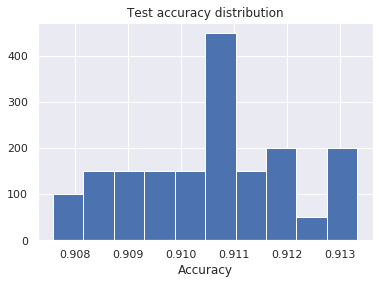

In [63]:
plt.hist(acc_test_list,bins=10,density=True)
plt.title('Test accuracy distribution')
plt.xlabel('Accuracy')
plt.savefig('test_acc_distrib.png')
plt.show()

In [64]:
len(acc_test_list)

35

In [66]:
avg_test=sum(acc_test_list)/len(acc_test_list)
print(avg_test)

0.910623950567533


In [74]:
# standard-deviation
std_dev=[(x-avg_test)**2 for x in acc_test_list]
std_dev=sum(std_dev)/len(acc_test_list)
std_dev=np.sqrt(std_dev)
print(std_dev)

0.0015031219105978782


In [69]:
# two-sided 2.5% pvalues 
print(sorted(acc_test_list)[0],sorted(acc_test_list)[-1])

0.9075928537846732 0.9133286318758815


In [75]:
pd.DataFrame.from_dict({'average':[avg_test],'std_dev':std_dev,'median':[sorted(acc_test_list)[17]],'2.5%':[sorted(acc_test_list)[0]],'97.5%':[sorted(acc_test_list)[-1]]})

,average,std_dev,median,2.5%,97.5%
0,0.910624,0.001503,0.910719,0.907593,0.913329


## FeedFowardNN Pytorch

In [18]:
# This function was already defined before in section Condition=f(review)/NN section
def csr_to_torch_float(csr):
    coo=csr.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape =coo.shape
    tensor=torch.sparse.FloatTensor(i, v, torch.Size(shape))
    
    return tensor

In [32]:
# This function was already defined before in section Condition=f(review)/NN section
def y_torch(train_y):
    classes=list(set(train_y))
    classes=sorted(classes)
    dic={target:i for i,target in enumerate(classes)}

    y=np.array([dic[target] for target in train_y])

    return torch.from_numpy(y).squeeze()

1 and 2 layers Models

In [20]:
class Classifier1L(nn.Module): #one hidden layer
    
    def __init__(self,vocab_size,hidden_dim,output_dim,drop_rate=0.3):
        
        super(Classifier1L, self).__init__()
        
        self.fc1=nn.Linear(vocab_size,hidden_dim)
        self.fc2=nn.Linear(hidden_dim,output_dim)
        self.drop=nn.Dropout(drop_rate)
        #Use Cross-Entropy loss requires not calculating probability from the network directly. The output of the last layer is fed to the loss function directly
        
    def forward(self,x): 
        out=self.fc1(x)   
        out=F.relu(out)
        out=self.drop(out)
        out=self.fc2(out)

        return out

In [21]:
class Classifier2L(nn.Module): #one hidden layer
    
    def __init__(self,vocab_size,hidden1_dim,hidden2_dim,output_dim,drop_rate=0.3):
        
        super(Classifier2L, self).__init__()
        
        self.fc1=nn.Linear(vocab_size,hidden1_dim)
        self.fc2=nn.Linear(hidden1_dim,hidden2_dim)
        self.fc3=nn.Linear(hidden2_dim,output_dim)
        self.drop=nn.Dropout(drop_rate)
        #Use Cross-Entropy loss requires not calculating probability from the network directly. The output of the last layer is fed to the loss function directly
        
    def forward(self,x): 
        out=self.fc1(x)   
        out=F.relu(out)
        out=self.drop(out)
        out=self.fc2(out)
        out=F.relu(out)
        out=self.drop(out)
        out=self.fc3(out)

        return out

Upload Data to S3

In [22]:
prefix='sentiment-review-tv10k'
data_dir='./data_s3/train'

In [23]:
x_train,x_test,y_train,y_test=train_test_split(reviews_tv10k,data.sentiment.values,test_size=0.3,random_state=323)

In [24]:
pickle.dump(x_train,open('data_s3/train/x_train.pkl','wb'))
pickle.dump(y_train,open('data_s3/train/y_train.pkl','wb'))
pickle.dump(x_test,open('data_s3/test/x_test.pkl','wb'))
pickle.dump(y_test,open('data_s3/test/y_test.pkl','wb'))

In [25]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

Send to train in remote instance

In [26]:
output_dim=len(set(y_train))
print(output_dim)

assert output_dim==len(set(y_test))

3


In [6]:
vocab_size=vocab_file['reviews_tv10k.pkl']
print(vocab_size)

10000


Train 2-layer model. Training script: ffn2layer_train.py

In [28]:
from sagemaker.pytorch import PyTorch
#2-LAYER TRAINING
estimator = PyTorch(entry_point="ffn2layer_train.py",
                    source_dir="ffn_training/",
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 30,
                        'vocab_size':vocab_size,
                        'hidden1_dim': 200,
                        'hidden2_dim':200,
                        'output_dim':output_dim,
                        'drop_rate':0.3
                    })

In [ ]:
# 1-LAYER TRAINING
estimator = PyTorch(entry_point="ffn_train.py",
                    source_dir="ffn_training/",
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 30,
                        'vocab_size':vocab_size,
                        'hidden_dim': 200,
                        'output_dim':output_dim,
                        'drop_rate':0.3
                    })

In [29]:
input_data

's3://sagemaker-us-east-2-113516067754/sentiment-review-tv10k'

In [30]:
# 2-layer training
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-23 09:54:59 Starting - Starting the training job...
2020-07-23 09:55:01 Starting - Launching requested ML instances......
2020-07-23 09:56:05 Starting - Preparing the instances for training......
2020-07-23 09:57:33 Downloading - Downloading input data...
2020-07-23 09:57:54 Training - Downloading the training image......
2020-07-23 09:58:56 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-23 09:58:57,542 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-23 09:58:57,571 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-23 09:59:00,594 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-23 09:59:00,850 sagemaker-containers INFO     Module ffn2layer_train does not provide a setup.py. 
Generating setup.py
2020-07-23 09:59:00

**Validation**

In [ ]:
s3 = boto3.client('s3')
s3.download_file(bucket,'sagemaker-pytorch-2020-07-19-20-57-52-787/output/model.tar.gz','model.tar.gz')

In [31]:
with open('ffn2layer_model_artifacts/model_info.pth','rb') as f:
    model_info=torch.load(f)
model_info

{'epochs': 30,
 'hidden1_dim': 200,
 'hidden2_dim': 200,
 'vocab_size': 10000,
 'output_dim': 3,
 'drop_rate': 0.3}

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Classifier2L(model_info['vocab_size'],model_info['hidden1_dim'],model_info['hidden2_dim'], model_info['output_dim'],model_info['drop_rate'])

with open('ffn2layer_model_artifacts/model.pth','rb') as f:
    model.load_state_dict(torch.load(f))

In [33]:
# Prepare validation set
x_test_torch=csr_to_torch_float(x_test)
y_test_torch=y_torch(y_test)

val_ds = torch.utils.data.TensorDataset(x_test_torch.to_dense(), y_test_torch)
val_dl=torch.utils.data.DataLoader(val_ds, batch_size=100)

In [37]:
# Prepare train set
x_train_torch=csr_to_torch_float(x_train)
y_train_torch=y_torch(y_train)

train_ds = torch.utils.data.TensorDataset(x_train_torch.to_dense(), y_train_torch)
train_dl=torch.utils.data.DataLoader(train_ds, batch_size=100)

In [35]:
try:
    acc_pytorch(model,val_dl)
except:
    print('Define function acc_pytorch() in section "FeedFoward-NN Pytorch"' )

90.77887478451655

In [38]:
try:
    acc_pytorch(model,train_dl)
except:
    print('Define function acc_pytorch() in section "FeedFoward-NN Pytorch"' )

99.91604427489119

Save model log data

In [39]:
logs.add_row('FFN Pytorch/reviews_tv10k/sentiment/{}/0.9991604427489119/0.9077887478451655'.format(json.dumps(model_info)))

## LSTM Pytorch

LSTM model class

In [7]:
class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, vocab_size,embedding_dim, hidden_dim,output_dim):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = x.t()
        lengths = x[0,:]
        reviews = x[1:,:]
        embeds = self.embedding(reviews)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        out = out[lengths - 1, range(len(lengths))]
        return out

Train function

In [ ]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    """
    This is the training method that is called by the PyTorch training script. The parameters
    passed are as follows:
    model        - The PyTorch model that we wish to train.
    train_loader - The PyTorch DataLoader that should be used during training.
    epochs       - The total number of epochs to train for.
    optimizer    - The optimizer to use during training.
    loss_fn      - The loss function used for training.
    device       - Where the model and data should be loaded (gpu or cpu).
    """

    # TODO: Paste the train() method developed in the notebook here.
    for epoch in range(1, epochs + 1):
            model.train()
            total_loss = 0
            for batch in train_loader:
                batch_X, batch_y = batch

                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                # TODO: Complete this train method to train the model provided.
                optimizer.zero_grad()
                predictions=model(batch_X)

                loss=loss_fn(predictions,batch_y)

                total_loss += loss.data.item()
                loss.backward()
                optimizer.step()

            print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))

### Train and test data

In [9]:
x_train,x_test,y_train,y_test=train_test_split(reviews_seq_csr50k,data['sentiment'].values,test_size=0.3,random_state=540)

In [10]:
y_train.shape

(148888,)

In [11]:
# Converts csr_matrix to Torch Long tensor
def csr_to_torch_long(csr):
    coo=csr.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.LongTensor(values)
    shape =coo.shape
    tensor=torch.sparse.LongTensor(i, v, torch.Size(shape))
    
    return tensor

Use small bacth to check that the code is working correctly

In [ ]:
x_train_torch=csr_to_torch_long(x_train[:1000])
y_train_torch=y_torch(y_train[:1000])

val_ds = torch.utils.data.TensorDataset(x_train_torch.to_dense(), y_train_torch)
val_dl=torch.utils.data.DataLoader(val_ds, batch_size=50)

In [ ]:
model=LSTMClassifier(vocab_size,100,100,3)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
train(model, val_dl, 5, optimizer,loss_fn, device)

### Sagemaker training

In [12]:
prefix='drugs-rev-LSTM'
data_dir='./lstm_s3/train'

In [13]:
pickle.dump(x_train,open('lstm_s3/train/x_train.pkl','wb'))
pickle.dump(y_train,open('lstm_s3/train/y_train.pkl','wb'))
pickle.dump(x_test,open('lstm_s3/test/x_test.pkl','wb'))
pickle.dump(y_test,open('lstm_s3/test/y_test.pkl','wb'))

In [19]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket='lstm-drugs-dataset', key_prefix=prefix)

In [25]:
vocab_size=vocab_file['reviews_seq_csr50k.pkl']
print(vocab_size)

48319


In [28]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="lstm_train.py", #training script
                    source_dir="lstm_training/",
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 20,
                        'vocab_size':vocab_size+1,#note the +1!
                        'embedding_dim':100,
                        'hidden_dim': 100,
                        'output_dim':3
                    })

In [29]:
input_data

's3://lstm-drugs-dataset/drugs-rev-LSTM'

In [30]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-24 12:06:52 Starting - Starting the training job...
2020-07-24 12:06:54 Starting - Launching requested ML instances......
2020-07-24 12:07:59 Starting - Preparing the instances for training......
2020-07-24 12:09:25 Downloading - Downloading input data
2020-07-24 12:09:25 Training - Downloading the training image......
2020-07-24 12:10:23 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-24 12:10:25,040 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-24 12:10:25,070 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-24 12:10:25,289 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-24 12:10:25,528 sagemaker-containers INFO     Module lstm_train does not provide a setup.py. 
Generating setup.py
2020-07-24 12:10:25,528 sag

### Validation

Download model artifacts using AWS CLI, or directly from the notebook.

In [ ]:
!aws s3 cp s3://sagemaker-us-east-2-113516067754/sagemaker-pytorch-2020-07-21-08-49-07-784/output/model.tar.gz model.tar.gz

In [ ]:
# or download files directly on the notebook
s3 = boto3.client('s3')
s3.download_file(bucket,'s3://sagemaker-us-east-2-113516067754/sagemaker-pytorch-2020-07-21-08-49-07-784/output/model.tar.gz','model_lstm.tar.gz')

**Validation data**

In [33]:
x_test_torch=csr_to_torch_long(x_test)
y_test_torch=y_torch(y_test)

val_ds = torch.utils.data.TensorDataset(x_test_torch.to_dense(), y_test_torch)
val_dl=torch.utils.data.DataLoader(val_ds, batch_size=100)

In [35]:
with open('lstm_model_artifacts/output/model_info.pth','rb') as f:
    model_info=torch.load(f)

model_info

{'epochs': 20,
 'embedding_dim': 100,
 'hidden_dim': 100,
 'vocab_size': 48320,
 'output_dim': 3}

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=LSTMClassifier(model_info['vocab_size'],model_info['embedding_dim'],model_info['hidden_dim'],model_info['output_dim']).to(device)

with open('lstm_model_artifacts/output/model.pth','rb') as f:
    model.load_state_dict(torch.load(f))

In [37]:
#it takes a few minutes...
try:
    acc_pytorch(model,val_dl)
except:
    print('Define function acc_pytorch() in section "FeedFoward-NN Pytorch"' )

89.01426108760381

Save model log data

In [41]:
log_data='LSTM Pytorch/reviews_csr50k/sentiment/{}//0.8901426108760381'.format(json.dumps(model_info))

In [42]:
logs.add_row(log_data)

In [104]:
logs.log_data

,name,data_X,data_y,params,train acc,test acc
0,random forest,reviews_cv5k,condition-0.05,"{""n_estimators"": 20, ""max_depth"": 500, ""max_fe...",0.992542,0.811025
1,random forest,reviews_cv5k,condition-0.05,"{""n_estimators"": 20, ""max_depth"": 700, ""max_fe...",0.993212,0.809121
2,random forest,reviews_cv5k,condition-0.05,"{""n_estimators"": 20, ""max_depth"": 300, ""max_fe...",0.978444,0.800259
3,random forest,reviews_cv5k,condition-0.05,"{""n_estimators"": 30, ""max_depth"": 300, ""max_fe...",0.981065,0.807029
4,NB,drugnames,condition-0.01,"{""alpha"": 1.0}",0.679175,0.67433
5,NB,drugnames,condition-0.01,"{""alpha"": 0.5}",0.697117,0.691114
6,NB,drugnames,condition-0.01,"{""alpha"": 0.01}",0.723874,0.713235
7,NB,drugnames,condition-0.01,"{""alpha"": 0.001}",0.724339,0.713893
8,Decision tree,drugnames,condition-0.01,"{""criterion"": ""gini"", ""max_depth"": 6000, ""max_...",0.724344,0.714504
9,random forest,drugnames,condition-0.01,"{""n_estimators"": 50, ""criterion"": ""entropy"", ""...",0.724297,0.714386


In [105]:
logs.save_data()